In [12]:
import shutil
import glob
import warnings
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import itertools
from IPython.display import Image
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# os.chdir('./dataset/Sign_Language_Digits')
# if os.path.isdir('train/0/') is False:
#     os.mkdir('train')
#     os.mkdir('valid')
#     os.mkdir('test')
    
#     for i in range(10):
#         shutil.move(f'{i}','train')
#         os.mkdir(f'valid/{i}')
#         os.mkdir(f'test/{i}')
        
#         valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
#         for j in valid_samples:
#             shutil.move(f'train/{i}/{j}',f'valid/{i}')
            
#         test_samples = random.sample(os.listdir(f'train/{i}'),10)
#         for j in test_samples:
#             shutil.move(f'train/{i}/{j}',f'test/{i}')
            
# os.chdir('./../..')

In [29]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title='confusion_matrix',
    cmap=plt.cm.Blues
):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalize confusion matrix')
    else:
        print('Confusion matrix without normalization')
        
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                 horizontalalignment = 'center',
                 color='white' if cm[i,j]> thresh else 'black'
                )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
train_path ='./dataset/Sign_Language_Digits/train'
valid_path ='./dataset/Sign_Language_Digits/valid'
test_path ='./dataset/Sign_Language_Digits/test'

In [4]:
train_batches = ImageDataGenerator(
        preprocessing_function=mobilenet.preprocess_input
    ).flow_from_directory(
        directory = train_path, 
        target_size = (224,224), 
        batch_size = 10
    )

valid_batches = ImageDataGenerator(
        preprocessing_function = mobilenet.preprocess_input
    ).flow_from_directory(
        directory = valid_path,
        target_size = (224,224),
        batch_size = 10
    )

test_batches = ImageDataGenerator(
        preprocessing_function = mobilenet.preprocess_input
    ).flow_from_directory(
        directory = test_path,
        target_size = (224,224),
        batch_size = 10,
        shuffle = False
    )

Found 1662 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [6]:
mobile = mobilenet.MobileNet()

In [7]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [10]:
x = mobile.layers[-6].output
x

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(None, 1024) dtype=float32>

In [11]:
output = Dense(units=10 ,activation='softmax')(x)

In [15]:
model = Model(inputs=mobile.input ,outputs= output)

In [17]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [20]:
len(mobile.layers)

93

In [21]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [23]:
model.compile(
    optimizer=Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
model.fit(
    x=train_batches, 
    validation_data=valid_batches, 
    epochs=10, 
    verbose=2
)

Epoch 1/10
167/167 - 58s - loss: 0.6192 - accuracy: 0.8237 - val_loss: 0.2731 - val_accuracy: 0.9100
Epoch 2/10
167/167 - 74s - loss: 0.1067 - accuracy: 0.9862 - val_loss: 0.1239 - val_accuracy: 0.9700
Epoch 3/10
167/167 - 71s - loss: 0.0638 - accuracy: 0.9910 - val_loss: 0.1065 - val_accuracy: 0.9867
Epoch 4/10
167/167 - 71s - loss: 0.0392 - accuracy: 0.9958 - val_loss: 0.0705 - val_accuracy: 0.9933
Epoch 5/10
167/167 - 71s - loss: 0.0267 - accuracy: 0.9976 - val_loss: 0.0507 - val_accuracy: 0.9967
Epoch 6/10
167/167 - 71s - loss: 0.0253 - accuracy: 0.9976 - val_loss: 0.0641 - val_accuracy: 0.9933
Epoch 7/10
167/167 - 69s - loss: 0.0157 - accuracy: 0.9988 - val_loss: 0.0502 - val_accuracy: 0.9967
Epoch 8/10
167/167 - 69s - loss: 0.0145 - accuracy: 0.9976 - val_loss: 0.0806 - val_accuracy: 0.9933
Epoch 9/10
167/167 - 69s - loss: 0.0131 - accuracy: 0.9994 - val_loss: 0.0568 - val_accuracy: 0.9967
Epoch 10/10
167/167 - 74s - loss: 0.0084 - accuracy: 0.9994 - val_loss: 0.0497 - val_accura

In [25]:
test_labels = test_batches.classes

In [26]:
predictions = model.predict(x=test_batches, verbose = 0)

In [27]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [28]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix without normalization
[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0 10]]


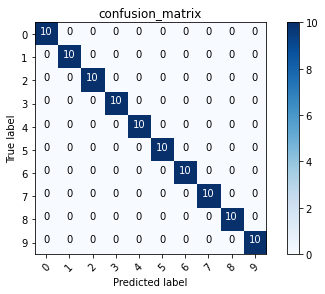

In [30]:
cm_plot_labels=['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)